In [1]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import os
import glob
import pandas as pd
import datetime

from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sqlalchemy import select

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from src.data.processing_func import connect_database
from src.data.load_func import transf_flow_labels

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 500)

It is important to remember that slots that show up in the following table can contain 1 or 2 signals from Waze. This may impact the model since it is an indicator of the overall duration of the traffic jam, in that section, during that period.

Remember to include that in the model in a future moment.

In [2]:
project_dir = os.path.join(".", os.pardir, os.pardir)

#Get processed datasets
filenames = glob.glob(project_dir+"/data/test/flow_dataset_*.csv")
filenames.sort()

frame = pd.DataFrame()
list_ = []
for file_ in filenames:
    df = pd.read_csv(file_, index_col=0)
    list_.append(df)
df = pd.concat(list_)
df.reset_index(inplace=True)
df = df[['SctnId', 'Endereco', 'SctnDscNome', 'Direction', 'date', 'hour', 'minute_bin',
         'Velocidade Média (km/h)', 'Atraso médio (s)', 'Fila média (m)', 'Nível médio de congestionamento (0 a 5)', 
         'Numero de faixas', 'Ciclofaixa', 'Corredor','Equipamento',
         '00 a 10', '11 a 20', '21 a 30', '31 a 40', '41 a 50', '51 a 60',
         '61 a 70', '71 a 80', '81 a 90', '91 a 100', 'Acima de 100', 'Total',
        ]]
print(df.shape)
df.sample(5)

(2698, 27)


,SctnId,Endereco,SctnDscNome,Direction,date,hour,minute_bin,Velocidade Média (km/h),Atraso médio (s),Fila média (m),Nível médio de congestionamento (0 a 5),Numero de faixas,Ciclofaixa,Corredor,Equipamento,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total
1528,10496.0,Rua Benjamin Constant 650,BENJAMIN CONSTANT,West,2017-11-17,18,30 a 44,10.320000,369.500000,1391.000000,3.500000,1,1,0,FS644JOI,0,0,7,81,53,0,0,0,0,0,0,141
438,5138.0,Rua Fátima. 542,FATIMA,South,2017-10-16,20,15 a 29,18.576667,151.666667,1592.000000,2.333333,1,0,0,FS640JOI,0,6,11,48,24,0,0,0,0,0,0,89
1858,7383.0,Av. José Vieira X Rua Itaiópolis,AVENIDA JOSE VIEIRA,South,2017-12-01,12,0 a 14,8.043333,134.333333,401.333333,3.000000,2,0,1,FS596JOI,0,124,143,81,6,0,0,0,0,0,0,354
456,5138.0,Rua Fátima. 542,FATIMA,South,2017-10-18,10,30 a 44,18.540000,74.000000,864.000000,2.000000,1,0,0,FS640JOI,0,1,11,40,35,3,0,0,0,0,0,90
2289,7383.0,Av. José Vieira X Rua Itaiópolis,AVENIDA JOSE VIEIRA,South,2017-12-13,17,30 a 44,7.470000,419.333333,1047.000000,4.000000,2,0,1,FS596JOI,2,127,137,70,1,1,0,0,0,0,0,338


Points with zero traffic count (Total) are odd, since they are matched with a traffic jam nearby. Let's remove these.

In [7]:
display(df.shape)
display(df[df["Total"]==0].shape)
df = df.loc[df["Total"]!=0]
display(df.shape)

(2656, 30)

(0, 30)

(2656, 30)

Due to buffer approximations, some radars belong simultaneously to more than one street section with similar traffic indicators. Since there might be a correlation between traffic congestion and traffic flow in subsequent sections, we'll leave all sections in the data set.

In [8]:
multiple_sections = df
multiple_sections = multiple_sections.groupby(["SctnId", "SctnDscNome",
                                               "Equipamento", "Direction"]).agg({"Total": 'mean',
                                                                                "date": 'count'})
multiple_sections.reset_index(inplace=True)
display(multiple_sections.sort_values(["Equipamento", "Total"], ascending=False))

,SctnId,SctnDscNome,Equipamento,Direction,Total,date
4,10496.0,BENJAMIN CONSTANT,FS644JOI,West,157.637255,102
1,5138.0,FATIMA,FS640JOI,South,96.391150,1130
3,8126.0,BLUMENAU,FS633JOI,South,304.875000,112
2,7383.0,AVENIDA JOSE VIEIRA,FS596JOI,South,322.086580,1155
0,937.0,AVENIDA JOSE VIEIRA,FS596JOI,South,306.870968,62
5,15651.0,MONSENHOR GERCINO,FS581JOI,West,117.052632,95


Below we check the relationship between the estimated speed on the section vs the actual speed measured through the radars.

It is clear that, although highly correlated, our estimate of average speed on the section is overly conservative and needs adjustment.

17.779086788878821

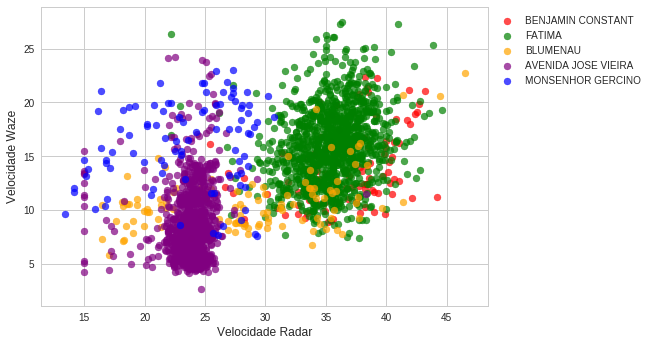

In [57]:
def weighted_average(x, avg_speeds):
    weighted_sum = 0
    for spd in avg_speeds:
        weighted_sum += x[spd]*avg_speeds[spd]
    weighted_avg = weighted_sum/x["Total"]
    
    return weighted_avg

avg_speeds = {"00 a 10": 5,
            "11 a 20": 15,
            "21 a 30": 25,
            "31 a 40": 35,
            "41 a 50": 45,
            "51 a 60": 55,
            "61 a 70": 65,
            "71 a 80": 75,
            "81 a 90": 85,
            "91 a 100": 95,
            "Acima de 100": 105}

df["weighted_avg"] = df.apply(lambda x: weighted_average(x, avg_speeds), axis=1)
df["spd_error"] = (df["Velocidade Média (km/h)"] - df["weighted_avg"])
df["spd_error_sqrd"] = df["spd_error"]**2
display((df["spd_error_sqrd"].sum()/df["spd_error_sqrd"].count())**(1/2))

fig, ax = plt.subplots()

equip_data1 = df[(df["Equipamento"]=="FS644JOI")]
ax.scatter(equip_data1["weighted_avg"],
           equip_data1["Velocidade Média (km/h)"],
           label='BENJAMIN CONSTANT',
           color='red',
           alpha=0.7)

equip_data2 = df[(df["Equipamento"]=="FS640JOI")]
ax.scatter(equip_data2["weighted_avg"],
            equip_data2["Velocidade Média (km/h)"],
            label='FATIMA',
            color='green',
            alpha=0.7)

equip_data3 = df[(df["Equipamento"]=="FS633JOI")]
ax.scatter(equip_data3["weighted_avg"],
            equip_data3["Velocidade Média (km/h)"],
            label='BLUMENAU',
            color='orange',
            alpha=0.7)

equip_data4 = df[(df["Equipamento"]=="FS596JOI") & (df["SctnId"]!=937.0)]
ax.scatter(equip_data4["weighted_avg"],
           equip_data4["Velocidade Média (km/h)"],
           label="AVENIDA JOSE VIEIRA",
           color='purple',
           alpha=0.7)

equip_data5 = df[(df["Equipamento"]=="FS581JOI")]
ax.scatter(equip_data5["weighted_avg"],
           equip_data5["Velocidade Média (km/h)"],
           label="MONSENHOR GERCINO",
           color='blue',
           alpha=0.7)

plt.ylabel("Velocidade Waze", fontsize=12)
plt.xlabel("Velocidade Radar", fontsize=12)
ax.legend(bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")


Before proceeding to a refinement in the method of estimating section average speed, let's see if there is a relationship between the speed accused by the radars and the flow measured in the same period

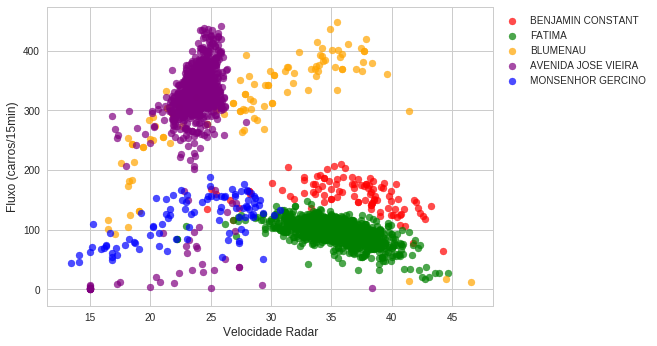

In [55]:
fig, ax = plt.subplots()

equip_data1 = df[(df["Equipamento"]=="FS644JOI")]
ax.scatter(equip_data1["weighted_avg"],
           equip_data1["Total"],
           label='BENJAMIN CONSTANT',
           color='red',
           alpha=0.7)

equip_data2 = df[(df["Equipamento"]=="FS640JOI")]
ax.scatter(equip_data2["weighted_avg"],
            equip_data2["Total"],
            label='FATIMA',
            color='green',
            alpha=0.7)

equip_data3 = df[(df["Equipamento"]=="FS633JOI")]
ax.scatter(equip_data3["weighted_avg"],
            equip_data3["Total"],
            label='BLUMENAU',
            color='orange',
            alpha=0.7)

equip_data4 = df[(df["Equipamento"]=="FS596JOI") & (df["SctnId"]!=937.0)]
ax.scatter(equip_data4["weighted_avg"],
           equip_data4["Total"],
           label="AVENIDA JOSE VIEIRA",
           color='purple',
           alpha=0.7)

equip_data5 = df[(df["Equipamento"]=="FS581JOI")]
ax.scatter(equip_data5["weighted_avg"],
           equip_data5["Total"],
           label="MONSENHOR GERCINO",
           color='blue',
           alpha=0.7)

plt.xlabel("Velocidade Radar", fontsize=12)
plt.ylabel("Fluxo (carros/15min)", fontsize=12)
ax.legend(bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")


To improve Waze's speed estimate, we'll get the traffic jams that explicitly include the radars - instead of getting all the street sections that intersected the jams in any form.

In [ ]:
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = connect_database(DATABASE)

query_all = select([
                JamDateStart,
                JamDscStreet,
                JamUuid,
                jam.c.JamId,
                jam.c.JamSpdMetersPerSecond,
                jam.c.JamTimeDelayInSeconds,
                jam.c.JamQtdLengthMeters,
                jam.c.JamDscCoordinatesLonLat])



In [5]:
X = df[['Velocidade Média (km/h)', 'Nível médio de congestionamento (0 a 5)', 'Atraso médio (s)',
       'Fila média (m)', 'Numero de faixas', 'Ciclofaixa', 'Corredor']]
y = df['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

clf = linear_model.LinearRegression()

clf.fit(X_train,y_train)
display(clf.score(X_test, y_test))


(3535, 7)

(1179, 7)

(3535,)

(1179,)

0.68314936963419282

In [6]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train)
neigh.score(X_test, y_test)

0.40410168549635461

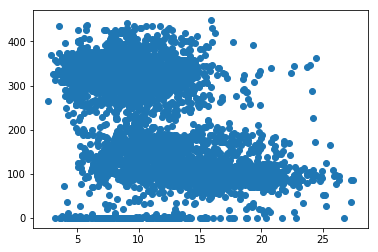

In [152]:
plt.scatter(X['Velocidade Média (km/h)'], y)
plt.show()

In [66]:
df["V_squared"] = df['Velocidade Média (km/h)']**2
df["V_cubic"] = df['Velocidade Média (km/h)']**3
df2 = df[df['Numero de faixas']>1]
df2 = df2[df2["Total"]>50]
df2 = df2[df2["hour"]==18]
X2 = df2['Velocidade Média (km/h)'].values.reshape(-1,1)
y2 = df2['Total']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=0)

display(X2_train.shape)
display(X2_test.shape)
display(y2_train.shape)
display(y2_test.shape)

clf = linear_model.LinearRegression()

clf.fit(X2_train,y2_train)
display(clf.score(X2_test, y2_test))

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X2_train,y2_train)
display(neigh.score(X2_test, y2_test))




(275, 1)

(92, 1)

(275,)

(92,)

-0.066792593555848656

-0.14708503156345754

In [2]:
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = connect_database(DATABASE)

path_fluxos = project_dir + "/data/external/fotosensores_Fluxo_veiculos.csv"
df_flow = transf_flow_labels(meta, path_fluxos)
df_flow.shape

(164160, 20)

In [64]:
df_flow[df_flow["SctnDscNome"]=="ITAIOPOLIS"].sample(5)
display(df_flow.index.get_level_values("Direction").unique())

Index(['West', 'East', 'North', 'South'], dtype='object', name='Direction')

,Total
date,
2017-10-03,2572
2017-10-04,2604
2017-10-05,2516
2017-10-06,2548
2017-10-07,2536
2017-10-08,2348
2017-10-09,2584
2017-10-10,2662
2017-10-11,2624


,Total
date,


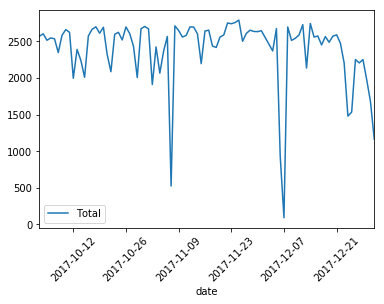

In [59]:
monsenhor = df_flow[df_flow["SctnDscNome"] == "ITAIOPOLIS"]
monsenhor = monsenhor.xs(18, level="hour").sort_index(level="date")
monsenhor = monsenhor.groupby(level="date").agg({"Total": 'sum'})
monsenhor = monsenhor[monsenhor["Total"] != 0]
display(monsenhor)

ax = monsenhor.reset_index().plot(x='date', y='Total')
plt.xticks(rotation=45)

monsenhor[monsenhor["Total"]<60]